In [2]:
import sys

sys.path.append("C:/Users/junsu/volatility_arbitrage")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

from volatility_arbitrage.pricing_model.heston_model import generate_inefficient_market
from volatility_arbitrage.pricing_model.interface import HestonParams, MarketModel
from volatility_arbitrage.pricing_model.weighted_variance_swap import VarianceSwap

# Model Setup

In [5]:
BDAYS = 252

length = BDAYS
time_delta = 1 / length
implied_vol = 0.2
realized_vol = 0.16
num_path = 10_000
rho_tilde = -0.8
rho = -0.6

real_model = HestonParams(kappa=5, mean_of_var=realized_vol**2, vol_of_var=0.5, rho=-0.4)
imp_model = HestonParams(kappa=5, mean_of_var=implied_vol**2, vol_of_var=0.5, rho=rho_tilde)

market_model = MarketModel(
    imp_model=imp_model, real_model=real_model, rho_real_var_imp_var=0.7, rho_spot_imp_var=rho
)

np.random.seed(0)
lr, real_var, imp_var = generate_inefficient_market(
    real_var_0=realized_vol**2,
    imp_var_0=implied_vol**2,
    market_model=market_model,
    num_path=num_path,
    length=length,
    time_delta=time_delta,
)

f = 100 * np.exp(np.cumsum(lr, axis=0))

# Realized Variance Estimation

In [14]:
def rolling_mean_columns(
    data: npt.NDArray[np.float64], window_size: int
) -> npt.NDArray[np.float64]:
    assert data.ndim == 2

    # Get the shape of the array
    n, k = data.shape

    # Calculate the new shape after applying the rolling window
    new_shape = (n - window_size + 1, window_size, k)

    # Use stride tricks to create a sliding window across rows
    strides = (data.strides[0],) + data.strides
    rolling_windows = np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=strides)

    # Compute the mean along the second axis (the rolling window axis)
    return rolling_windows.mean(axis=1)

In [35]:
window_size = 21
gamma_pnl = 2 * (np.exp(lr[1:]) - 1 - lr[1:])
real_var_est = rolling_mean_columns(gamma_pnl, window_size) / time_delta
integrated_real_var = rolling_mean_columns(real_var[1:], window_size)
real_var_rel_err = (real_var_est / integrated_real_var).flatten() - 1
real_var_abs_err = (real_var_est - integrated_real_var).flatten()

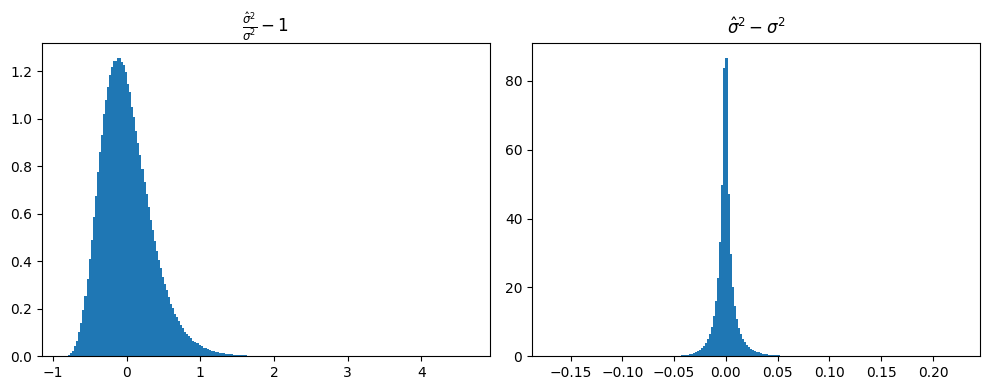

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(real_var_rel_err, density=True, bins=200)
ax[0].set_title(r"$\frac{\hat{\sigma}^2}{\sigma^2} - 1$")

ax[1].hist(real_var_abs_err, density=True, bins=200)
ax[1].set_title(r"$\hat{\sigma}^2 - \sigma^2$")

fig.tight_layout()
plt.show()

# Implied Variance Estimation

In [52]:
variance_swap = VarianceSwap(market_model=market_model)
imp_var_est = variance_swap.price(imp_var=imp_var, tau=1 / BDAYS) * BDAYS

imp_var_rel_err = (imp_var_est / imp_var).flatten() - 1
imp_var_abs_err = (imp_var_est - imp_var).flatten()

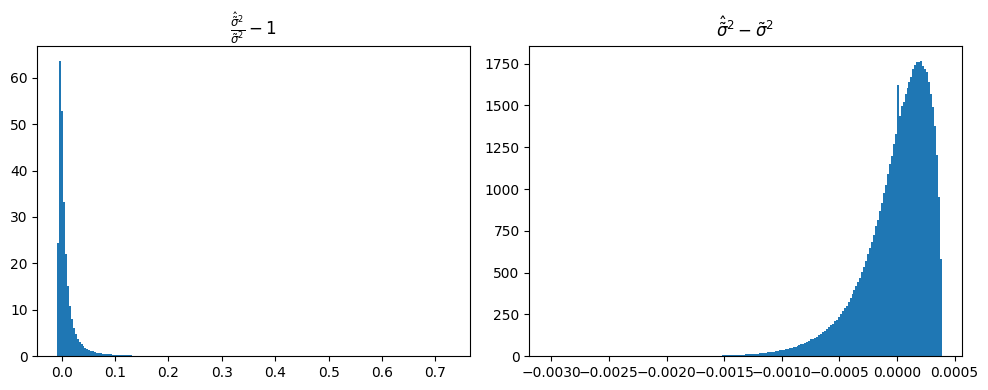

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(imp_var_rel_err, density=True, bins=200)
ax[0].set_title(r"$\frac{\hat{\tilde{\sigma}}^2}{\tilde{\sigma}^2} - 1$")

ax[1].hist(imp_var_abs_err, density=True, bins=200)
ax[1].set_title(r"$\hat{\tilde{\sigma}}^2 - \tilde{\sigma}^2$")

fig.tight_layout()
plt.show()